In [1]:
from datetime import datetime,timedelta
import praw
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

# Initialize Reddit instance
reddit = praw.Reddit(client_id="QceghOvKUG-WtgWj3PIW6A",
                     client_secret="KjyiD4tRB19m1Cvdcva9g831vAWtfQ",
                     user_agent="Sentiment Analysis")

In [2]:
# Setup Reddit Comments
comments_data = []

subreddit = reddit.subreddit('NewYorkMets')
    
results = subreddit.search('PREGAME THREAD', sort='new', limit=275)

# Loop through each submission
for submission in results:
    print(f"Found submission: {submission.title}")
    submission.comments.replace_more(limit=100)  # Replace "more comments"

    # Loop through each comment in the submission
    for comment in submission.comments.list():
        comment_time = datetime.utcfromtimestamp(comment.created_utc)
        comments_data.append({
            'post_title': submission.title,
            'comment_time': comment_time,
            'comment': comment.body
        })

# Now you can use 'comments_data' for further processing or conversion to a DataFrame.
print(f"Total comments collected: {len(comments_data)}")


# Convert to DataFrame
df = pd.DataFrame(comments_data)
df = df.sort_values(by = 'comment_time')

Found submission: Mets PREGAME THREAD - Wednesday, April 16
Found submission: Mets PREGAME THREAD - Tuesday, April 15
Found submission: Mets PREGAME THREAD - Monday, April 14
Found submission: Mets PREGAME THREAD - Sunday, April 13
Found submission: Mets PREGAME THREAD - Saturday, April 12
Found submission: Mets PREGAME THREAD - Friday, April 11
Found submission: Mets PREGAME THREAD - Wednesday, April 09
Found submission: Mets PREGAME THREAD - Tuesday, April 08
Found submission: Mets PREGAME THREAD - Monday, April 07
Found submission: Mets PREGAME THREAD - Sunday, April 06
Found submission: Mets PREGAME THREAD - Saturday, April 05
Found submission: Mets PREGAME THREAD - Friday, April 04
Found submission: Mets PREGAME THREAD - Wednesday, April 02
Found submission: Mets PREGAME THREAD - Tuesday, April 01
Found submission: Mets PREGAME THREAD - Monday, March 31
Found submission: Mets PREGAME THREAD - Saturday, March 29
Found submission: Mets PREGAME THREAD - Friday, March 28
Found submiss

In [6]:
# Clean Comments / Convert the list of comments to a DataFrame
df = pd.DataFrame(comments_data)

# Ensure 'comment_time' is a datetime type
df['comment_time'] = pd.to_datetime(df['comment_time'])

#Clean Data
df = df[~df['comment'].str.contains(r'\[removed\]|\[deleted\]|\[Moderators will remove posts or comments]')]
                                    
df['comment'] = df['comment'].apply(
    lambda x: ' '.join([
        word.replace('[', '')
            .replace('â€™', "'")
            
        for word in x.split() if 'http' not in word
    ])
)

#Create CSV to check comments for further editing
df.to_csv('check_comments.csv', index=False)

In [103]:
#Read in Mets Betting Lines
mets_odds = pd.read_csv('mets.csv')

mets_odds['Date'] = pd.to_datetime(mets_odds['Date'].astype(str).str.strip(), errors='coerce').dt.strftime('%m/%d/%Y')
mets_odds = mets_odds[mets_odds['Date'].notna()]


#Read in Mets Gametimes
mets_gametime = pd.read_csv('2024_mets_schedule.csv')
mets_gametime['Date'] = pd.to_datetime(mets_gametime['Date'].astype(str).str.strip(), errors='coerce').dt.strftime('%m/%d/%Y')
mets_gametime = mets_gametime[mets_gametime['Date'].notna()]
#print(mets_gametime.dtypes)

mets_sentiment = pd.read_csv('2024_mets_sentiment.csv')
mets_sentiment['Date'] = pd.to_datetime(mets_sentiment['Date'].astype(str).str.strip(), errors='coerce').dt.strftime('%m/%d/%Y')
mets_sentiment = mets_sentiment.sort_values(by='Date', ascending=True)
#print(mets_sentiment.dtypes)

merged_odds_time = mets_gametime.merge(mets_odds, on='Date', how='right')
#merged_odds_time.head(100)



In [8]:
game_times = pd.to_datetime(merged_odds_time[['year', 'month', 'day', 'hour', 'minute']])

filtered_comments = []
for game_time in game_times:
    start_time = game_time.replace(hour=0, minute=0, second=0, microsecond=0)
    end_time = game_time
    
    filtered = df[(df['comment_time'] > start_time) & (df['comment_time'] < end_time)].copy()
    filtered['game_date'] = game_time.date()  # optional: add game date for grouping later
    filtered_comments.append(filtered)

# Combine all into one DataFrame
df_filtered = pd.concat(filtered_comments, ignore_index=True)
del df_filtered['post_title']

# Preview
print(df_filtered.shape)
df_filtered.head()

(17576, 3)


,comment_time,comment,game_date
0,2024-03-29 12:10:47,I can't watch the game since I'll be working c...,2024-03-29
1,2024-03-29 11:33:07,MEET THE METS MEET THE METS STEP RIGHT UP AND ...,2024-03-29
2,2024-03-29 10:51:30,I love that we own the stat for best Opening D...,2024-03-29
3,2024-03-29 10:02:38,A lot of runs scored on opening day. Thinkin t...,2024-03-29
4,2024-03-29 12:15:26,"Controversial thought but, LETS GO METS",2024-03-29


In [10]:
# Load RoBERTa model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Helper function to get sentiment scores
def roberta_sentiment(text):
    # Tokenize and predict
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    return {
        'neg': scores[0],
        'neu': scores[1],
        'pos': scores[2],
        'compound': scores[2]-scores[0]
    }

In [11]:
# Apply sentiment analysis (use tqdm for a progress bar)
sentiments = []
for comment in tqdm(df_filtered['comment'], desc="Running RoBERTa sentiment analysis"):
    scores = roberta_sentiment(comment)
    sentiments.append(scores)

# Convert list of dicts to DataFrame and merge with df_filtered
sentiment_df = pd.DataFrame(sentiments)
df_filtered = pd.concat([df_filtered.reset_index(drop=True), sentiment_df], axis=1)

Running RoBERTa sentiment analysis: 100%|██████████| 17576/17576 [32:02<00:00,  9.14it/s] 


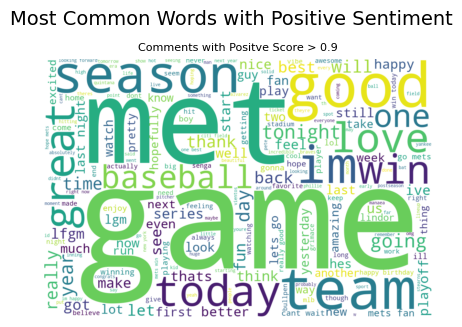

In [228]:
#CREATE WORD CLOUD

# Filter comments labeled as positive
positive_comments = df_filtered[df_filtered['pos'] > .9]['comment']


# Combine comments into a single string
text = " ".join(positive_comments)

# Clean the text
text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
text = re.sub(r'\@\w+|\#','', text)
text = re.sub(r'[^A-Za-z\s]', '', text)
text = text.lower()
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(text)

plt.figure(figsize=(5,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.suptitle("Most Common Words with Positive Sentiment", fontsize = 14, y=.75)
plt.title("Comments with Positve Score > 0.9", fontsize=8)
plt.show()




In [43]:
#Group By Game Date
grouped_sentiment = df_filtered.groupby('game_date').agg({
    'neg': 'mean',
    'neu': 'mean',
    'pos': 'mean',
    'compound': 'mean',
    'comment': 'size'
}).reset_index()

grouped_sentiment.rename(columns={'comment': 'num_comments'}, inplace=True)
grouped_sentiment = grouped_sentiment.sort_values(by='game_date')

# Convert game_date to match mets_odds['Date'] format
grouped_sentiment['Date'] = pd.to_datetime(grouped_sentiment['game_date'].astype(str).str.strip(), errors='coerce').dt.strftime('%m/%d/%Y')
grouped_sentiment = grouped_sentiment.drop(columns=['game_date'])

grouped_sentiment = grouped_sentiment.sort_values(by = 'Date')
grouped_sentiment.head(50)



KeyError: "Column(s) ['negative', 'neutral', 'positive'] do not exist"

Text(0, 0.5, 'Total Sentiment')

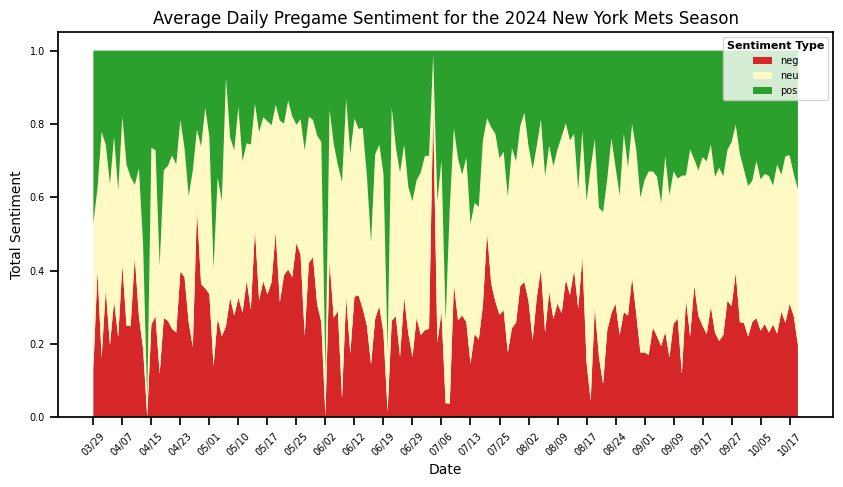

In [229]:
#-------- Create Area Map -------------#
area_map_df = grouped_sentiment.drop(columns= ['num_comments','compound'])
area_map_df = area_map_df.melt(id_vars = 'Date')
#area_map_df
x = area_map_df['Date'].unique()
x = [date.split('/')[0] + '/' + date.split('/')[1] for date in x]


senti_dict = (area_map_df.groupby('variable')['value']
            .apply(lambda x: x.values.tolist())
            .to_dict())



labels = senti_dict.keys()
#labels
plt.figure(figsize=(10,5))

senti_values = senti_dict.values()
    
plt.stackplot(x,
              senti_values,
              labels = labels,
             colors=['#D62728', '#FFF9C4','#2CA02C'])

plt.xticks(ticks=x[::7], rotation=45, fontsize=7)
plt.yticks(fontsize=7)

legend = plt.legend(loc='upper right', title = 'Sentiment Type', prop={'size':7})
plt.setp(legend.get_title(), fontsize='8', fontweight='bold')

plt.title('Average Daily Pregame Sentiment for the 2024 New York Mets Season')
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Total Sentiment', fontsize = 10)

In [227]:
#Merge Sentiment with odds
final_merged = merged_odds_time.merge(grouped_sentiment, on='Date', how='right')
final_merged.head(100)
#final_merged.to_csv('final_sentiment_odds.csv', index = False)

<Figure size 1000x1000 with 0 Axes>

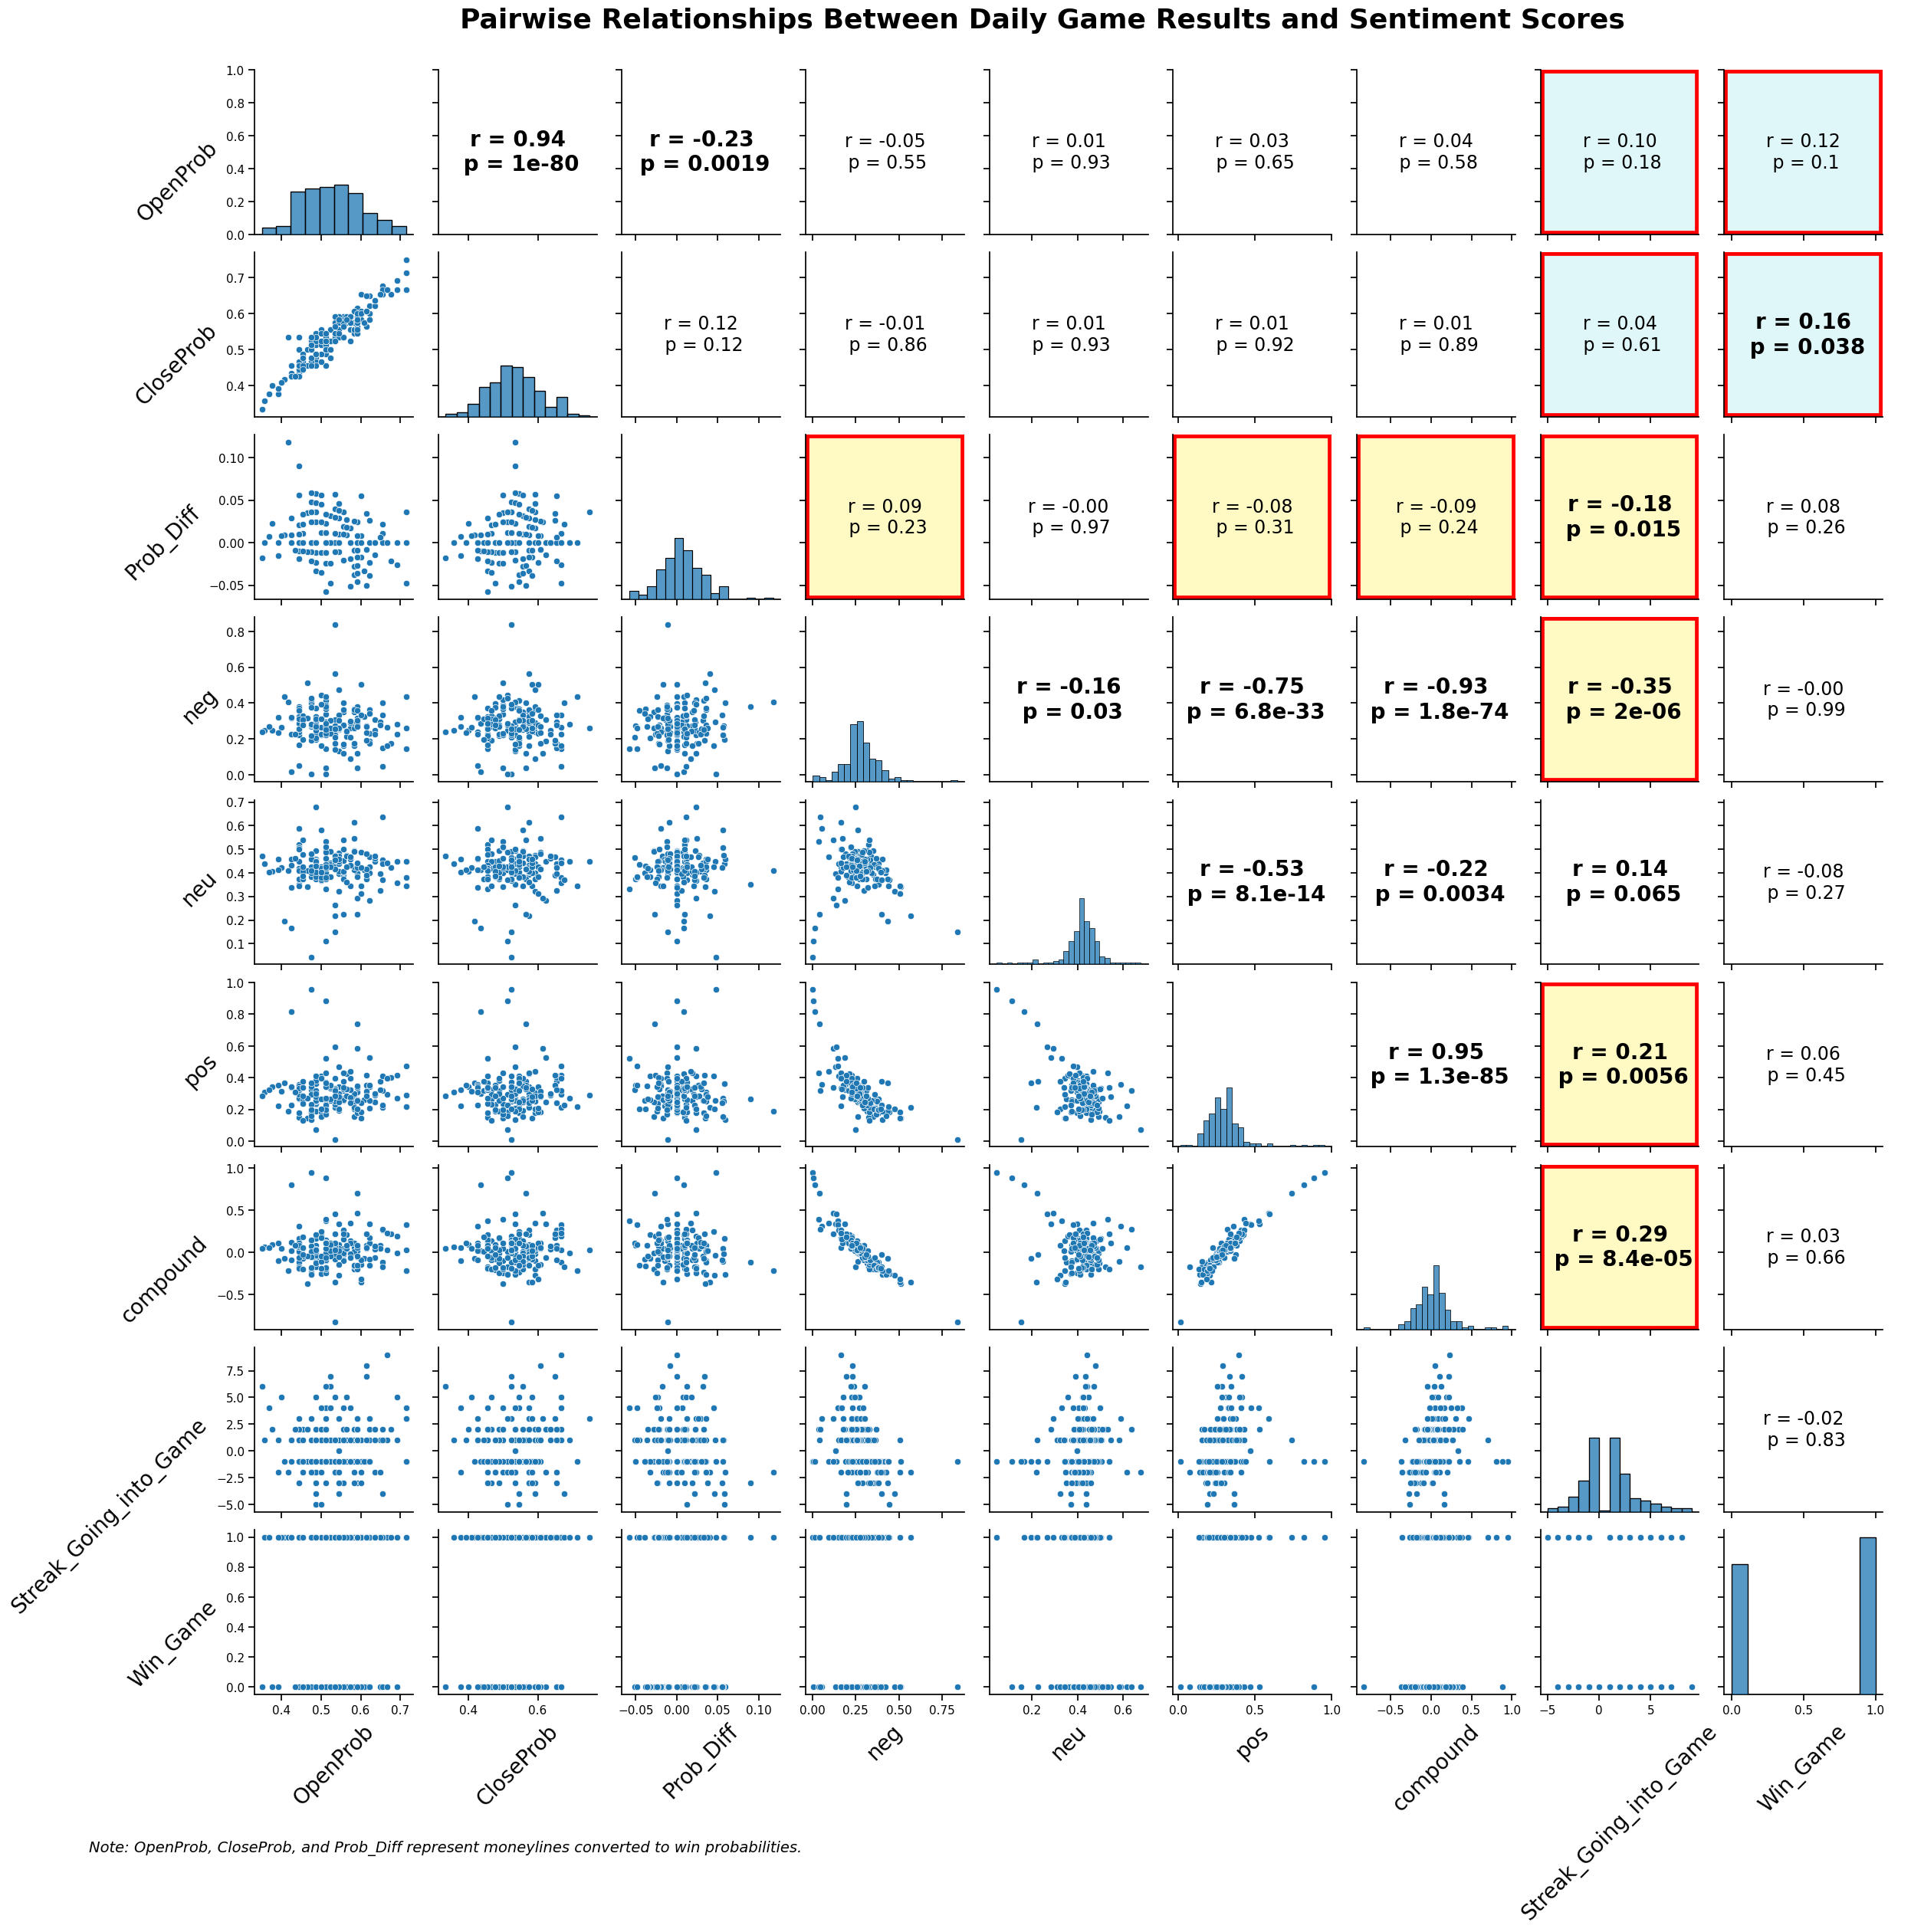

In [226]:
import seaborn as sns
from scipy.stats import pearsonr
import warnings
import matplotlib.patches as patches

warnings.filterwarnings("ignore")

pairs_df = final_merged[['OpenProb','CloseProb','Prob_Diff','neg','neu','pos','compound',
                         'Streak_Going_into_Game','Win_Game']]

plt.figure(figsize=(10,10))
sns.set_context("notebook",rc={"axes.labelsize":20})

def corrfunc(x, y, **kwargs):
    r, p = pearsonr(x, y)
    ax = plt.gca()
    size = 20 if p < .1 else 17
    weight = 'bold' if p < .1 else None
    ax.annotate(f'r = {r:.2f}\n p = {p:.2g}', 
                xy=(.5, .5), xycoords=ax.transAxes,
                ha='center', va='center',
                fontsize=size, fontweight=weight)

g = sns.PairGrid(pairs_df)
g.map_diag(sns.histplot)
g.map_upper(corrfunc)
g.map_lower(sns.scatterplot)
g.add_legend()

# Add title and caption
plt.suptitle("Pairwise Relationships Between Daily Game Results and Sentiment Scores", fontsize=26, fontweight='bold', y=1.02)
plt.figtext(-0.05, -0.05, "Note: OpenProb, CloseProb, and Prob_Diff represent moneylines converted to win probabilities.", 
            wrap=True, horizontalalignment='left', fontsize=14, style='italic')


for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation = 45)
    ax.set_ylabel(ax.get_ylabel(), rotation = 45)
    ax.yaxis.get_label().set_horizontalalignment('right')
    
# Variables to highlight: y-axis is fixed, x-axis has multiple vars
highlight_y = 'Prob_Diff'
highlight_x = ['compound', 'pos', 'neg','Streak_Going_into_Game']

# Get variable positions from PairGrid
var_to_idx = {var: i for i, var in enumerate(g.x_vars)}

# Loop through the x variables and highlight only (y, x) in lower triangle
for x_var in highlight_x:

    row = var_to_idx[highlight_y]
    col = var_to_idx[x_var]
    ax = g.axes[row][col]
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=7, edgecolor='red', facecolor='#fff9c4')
    ax.add_patch(rect)
    
# Variables to highlight: y-axis is fixed, x-axis has multiple vars
highlight_y1 =  ['compound', 'pos', 'neg']
highlight_x1 ='Streak_Going_into_Game'

# Get variable positions from PairGrid
var_to_idx = {var: i for i, var in enumerate(g.x_vars)}

# Loop through the x variables and highlight only (y, x) in lower triangle
for y_var in highlight_y1:

    col = var_to_idx[highlight_x1]
    row = var_to_idx[y_var]
    ax = g.axes[row][col]
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=7, edgecolor='red', facecolor='#fff9c4')
    ax.add_patch(rect)
    
# Variables to highlight: y-axis is fixed, x-axis has multiple vars
highlight_y2 =  ['CloseProb', 'OpenProb']
highlight_x2 = ['Streak_Going_into_Game', 'Win_Game']

# Get variable positions from PairGrid
var_to_idx = {var: i for i, var in enumerate(g.x_vars)}

# Loop through the x variables and highlight only (y, x) in lower triangle
for y_var in highlight_y2:
    for x_var in highlight_x2:

        col = var_to_idx[x_var]
        row = var_to_idx[y_var]
        ax = g.axes[row][col]
        rect = patches.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes,
            linewidth=7, edgecolor='red', facecolor='#e0f7fa')
        ax.add_patch(rect)
    
g.savefig("pairplot_analysis.png", dpi=300, bbox_inches='tight')
